In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, GlobalAveragePooling2D
from keras.layers import Reshape, Dropout, Flatten, LeakyReLU
from keras.activations import softmax
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())
import time
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [3]:
def build_discriminator():
    
    dropout = 0.4
    model = Sequential()

    model.add(Conv2D(64,5,strides=2,input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(128,5,strides=2,padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(256,5,strides=2,padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(512,5,strides=1,padding='same'))
    model.add(LeakyReLU(0.2))

    # global average pooling
    model.add(GlobalAveragePooling2D())
    
    img = Input(shape=(28,28,1))
    gap_features = model(img)
    valid = Dense(1, activation='sigmoid')(gap_features)
    label = Dense(11,activation='softmax')(gap_features)
    
    return Model(img,[valid,label])

In [4]:
def build_generator():
    dropout = 0.4
    model = Sequential()
    
    model.add(Dense(7*7*256,input_dim=100))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))
    model.add(Reshape((7,7,256)))
    model.add(Dropout(dropout))
    
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128,5,padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))
    
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64,5,padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))
    
    model.add(Conv2DTranspose(32,5,padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))
    
    model.add(Conv2DTranspose(1,5,padding='same'))
    model.add(Activation('tanh'))
    
    noise = Input(shape=(100,))
    img = model(noise)
    
    return Model(noise, img)

In [5]:
def build_gan(generator, discriminator):
    noise = Input(shape=(100,))
    img = generator(noise)
    valid, _ = discriminator(img)
    return Model(noise, valid)

In [6]:
optimizer = Adam(lr=0.0002)
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss=['binary_crossentropy','categorical_crossentropy'],
                      loss_weights=[0.5, 0.5],
                      metrics=['acc'],
                      optimizer=optimizer)
discriminator.trainable = False
gan = build_gan(generator,discriminator)
gan.compile(loss='binary_crossentropy',
            optimizer=optimizer)
discriminator.trainable = True

In [7]:
def mask(data, labels):
    n = len(data)
    label_rate = 0.0016
    label_index = np.random.randint(n, size=int(n*label_rate))
    data_with_label = data[label_index]
    data_unlabel = data[~label_index]
    new_labels = labels[label_index]
    new_labels = to_categorical(new_labels, num_classes=11)
    return data_with_label, data_unlabel, new_labels

In [8]:
def train(X, y, batch, epochs, discriminator, generator, gan):    
    rounds = len(X) // batch
    for epoch in tqdm(range(epochs)):
        for rou in range(rounds + 1):
            if rou == rounds:
                data, labels = X[rou * batch:], y[rou * batch:]
            else:
                data, labels = X[rou * batch:(rou + 1) * batch], y[rou * batch:(rou + 1) * batch]
            if len(data) == 0:
                break

            labeled,  unlabeled, new_label = mask(data, labels)
            fake_labels = to_categorical(10*np.ones((len(data),1)),num_classes=11)
            valid = np.ones(len(labeled)) - 0.1

            # create random noise for generator input 
            noise_size = len(data)
            noise = np.random.normal(size = (noise_size, 100))

            # train discriminator on fake data
            discriminator.trainable = True
            fake = generator.predict_on_batch(noise)
            zeros = np.zeros(noise_size)
            
            discriminator.train_on_batch(fake, [zeros, fake_labels])

            # train discriminator on real labeled data
            discriminator.train_on_batch(labeled, [valid, new_label])
            
            # train generator
            discriminator.trainable = False
            ones = np.ones(noise_size)
            gan.train_on_batch(noise, ones)
            

In [9]:
epochs= 20
batch = 1000
t1 = time.time()
train(X_train, y_train, batch, epochs, discriminator, generator, gan)
print(time.time() - t1)

100%|██████████| 100/100 [19:46<00:00, 11.87s/it]

1186.7803766727448


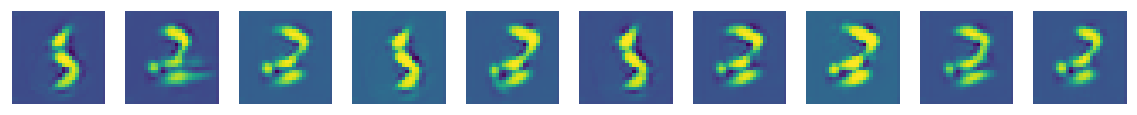

In [10]:
fig = plt.figure(figsize = (20, 4))
n = 10
for i in range(n):
    # original
    gen = generator.predict(np.random.normal(0,1,size=(1,100)))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(gen.reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('images/label_rate_{}_100.png'.format(0.0016),bbox_inches='tight')

In [11]:
def get_label(one_hot):
    return np.argmax(y_pred,1)

In [12]:
_, y_pred = discriminator.predict(X_test)
y_pred = get_label(y_pred)

In [13]:
(y_pred == y_test).sum()/len(y_test)

0.1903

In [14]:
accuracy = {0.2:0.9632, 0.02:0.8525, 0.0016:0.5132}